In [117]:
import serial
import struct
from dataclasses import dataclass, asdict

In [2]:
PORT = '/dev/ttyACM0'

In [3]:
serial_params = dict(
    port = PORT,
    baudrate = 9600,
    bytesize = serial.EIGHTBITS,
    stopbits = serial.STOPBITS_ONE,
    timeout = 0.5,
)

In [83]:
def checksum_bytes(ba):
    ushorts = [i[0] for i in struct.iter_unpack('<H', ba)]
    cs = (0xffff - sum(ushorts)) % 0xffff
    return struct.pack('<H', cs)

In [292]:
class ChecksumError(Exception):
    pass

In [313]:
@dataclass
class RequestPing:
    # This might actually be incorrect?
    # Looks like 7B FF 00 00 00 00 C7 01 00 00 BC FE
    # But it still responds so...
    packet_number: int
    prefix: int = 0xff7b
    command: int = 0x0020
    extension_length: int = 0x0000
    
    def __iter__(self):
        for i in asdict(self).items():
            yield i
        
    def __bytes__(self):
        base_command = struct.pack('<HHHBxxx', self.prefix,self.command,self.extension_length,self.packet_number)
        base_checksum = checksum_bytes(base_command)
        return base_command + base_checksum

In [317]:
@dataclass
class ResponsePing:
    # Base
    packet_number: int = None # whatever
    prefix: int = None # 0x7b
    command: int = None # 0x8020
    extension_length: int = None # 0x01
    
    cs1: int = None
    
    def parse_bytes(self, res):
        base_command = res[:12]
        if not checksum_bytes(base_command[:-2]) == base_command[-2:]:
            raise ChecksumError("Basecommand checksum failed", res)
            
        (
            self.prefix,
            self.command,
            self.extension_length,
            self.packet_number,
            self.cs1,
        ) = struct.unpack("<HHHBxxxH", res)
        return self
        
    def __iter__(self):
        for i in asdict(self).items():
            yield i
        

In [273]:
@dataclass
class RequestSerial:
    packet_number: int
    prefix: int = 0xff7b
    command: int = 0x0020
    extension_length: int = 0x0006
    subcommand: int = 0x0001
    reserved1: int = 0x000c
    
    def __iter__(self):
        for i in asdict(self).items():
            yield i
        
    def __bytes__(self):
        base_command = struct.pack('<HHHBxxx', self.prefix,self.command,self.extension_length,self.packet_number)
        base_checksum = checksum_bytes(base_command)
        sub_command = struct.pack('<HH', self.subcommand, self.reserved1)
        sub_checksum = checksum_bytes(sub_command)
        
        return base_command + base_checksum + sub_command + sub_checksum

In [370]:
# e.g.
# 7AFF20801E00230000002380010000001400000016A40000CE130000E407090F000F480328000000A91E
# NB - Command becomes 0x8020 from originating 0x0020
# Response header is ALWAYS 0x8020?

@dataclass
class ResponseSerial:
    # Base
    packet_number: int = None # whatever
    prefix: int = None # 0x7b
    command: int = None # 0x8020
    extension_length: int = None # 0x01
    
    # Sub
    subcommand: int = None # 0x0001
    SN: int = None
    YEAR: int = None
    MONTH: int = None
    DAY: int = None
    MAJ: int = None
    MIN: int = None
    SN2: int = None
        
    cs1: int = None
    cs2: int = None
        
    @property
    def VERSION(self):
        return f"{self.MAJ}.{self.MIN}"

    @property
    def SERIAL(self):
        return f"{self.DAY:02d}{self.MONTH:02d}{self.YEAR % 1000:2d}-{self.SN2:04}-{self.SN:06}"
    
    def parse_bytes(self, res):
        base_command = res[:12]
        if not checksum_bytes(base_command[:-2]) == base_command[-2:]:
            raise ChecksumError("Basecommand checksum failed", res)

        sub_command = res[12:]
        if not checksum_bytes(sub_command[:-2]) == sub_command[-2:]:
            raise ChecksumError("Subcommand checksum failed", res)
            
        (
            self.prefix,
            self.command,
            self.extension_length,
            self.packet_number,
            self.cs1,
            self.subcommand,
            self.SN,
            self.YEAR,
            self.MONTH,
            self.DAY,
            self.MAJ,
            self.MIN,
            self.SN2,
            self.cs2
        ) = struct.unpack("<HHHBxxxH    H 10x H 2x HBB BB H 4x H", res)
        return self
        
    def __iter__(self):
        for i in asdict(self).items():
            yield i
        

In [384]:
@dataclass
class RequestValues:
    packet_number: int
    prefix: int = 0xff7b
    command: int = 0x0020
    extension_length: int = 0x0006
    subcommand: int = 0x0804
    reserved1: int = 0x000c
    
    def __iter__(self):
        for i in asdict(self).items():
            yield i
        
    def __bytes__(self):
        base_command = struct.pack('<HHHBxxx', self.prefix,self.command,self.extension_length,self.packet_number)
        base_checksum = checksum_bytes(base_command)
        sub_command = struct.pack('<HH', self.subcommand, self.reserved1)
        sub_checksum = checksum_bytes(sub_command)
        
        return base_command + base_checksum + sub_command + sub_checksum

In [450]:
@dataclass
class RequestU1:
    packet_number: int
    prefix: int = 0xff7b
    command: int = 0x0020
    extension_length: int = 0x0006
    subcommand: int = 0x000b
    reserved1: int = 0x000c
    
    def __iter__(self):
        for i in asdict(self).items():
            yield i
        
    def __bytes__(self):
        base_command = struct.pack('<HHHBxxx', self.prefix,self.command,self.extension_length,self.packet_number)
        base_checksum = checksum_bytes(base_command)
        sub_command = struct.pack('<HH', self.subcommand, self.reserved1)
        sub_checksum = checksum_bytes(sub_command)
        
        return base_command + base_checksum + sub_command + sub_checksum

In [475]:
@dataclass
class RequestU2:
    packet_number: int
    prefix: int = 0xff7b
    command: int = 0x0020
    extension_length: int = 0x0006
    subcommand: int = 0x0007
    reserved1: int = 0x000b
    
    def __iter__(self):
        for i in asdict(self).items():
            yield i
        
    def __bytes__(self):
        base_command = struct.pack('<HHHBxxx', self.prefix,self.command,self.extension_length,self.packet_number)
        base_checksum = checksum_bytes(base_command)
        sub_command = struct.pack('<HH', self.subcommand, self.reserved1)
        sub_checksum = checksum_bytes(sub_command)
        
        return base_command + base_checksum + sub_command + sub_checksum

In [465]:
with serial.Serial(**serial_params) as port:
    port.write(bytes(RequestSerial(0x69)))
    res = port.read(128)

In [608]:
# Possibly we want to parse the BaseCommand portion, get the extension length,
# Then read the subcommand based on that length.
with serial.Serial(**serial_params) as port:
    port.write(bytes(RequestPing(1)))
    ping_response = ResponsePing().parse_bytes(port.read(64))
    print(ping_response)
    
    port.write(bytes(RequestSerial(2)))
    res = port.read(64)
    serial_response = ResponseSerial().parse_bytes(res)
    print(serial_response)
    
    port.write(bytes(RequestValues(0x2b)))
    res = port.read(128)

ResponsePing(packet_number=1, prefix=65402, command=32800, extension_length=0, cs1=32867)
ResponseSerial(packet_number=2, prefix=65402, command=32800, extension_length=30, subcommand=1, SN=5070, YEAR=2020, MONTH=9, DAY=15, MAJ=0, MIN=15, SN2=840, cs1=32836, cs2=7849)


In [609]:
res.hex()

'7aff20803a002b000000ff7f04080000300000000000140070430e486d9506439f0b7941b0672a4248615f8f990000002549824269d93a4386309d4345e803435e0200007b61'

In [563]:
res.hex()

'7aff20800e002b0000002b80070000005077639099000000abf7'

In [511]:
0x

17309

In [528]:
0x41,0x84
f"{198:x}"

'c6'

```
e3 8f 40 46 31 3e
e0 ee 40 b0 55 54
9e 7b 41 58 26 3d
56 7f 41 78 76 3b

95 E8 40 81 F5 1E


BF F9 40 BE 9E 1B
9A F8 40 C2 6B 1B
BF F9 40 BA DA 1B
05 F0 40 AB A3 1C
```

In [443]:
print(struct.unpack('<HHH',b'\xe3\x8f\x40\x46\x31\x3e'))
print(struct.unpack('<HHH',b'\xe0\xee\x40\xb0\x55\x54'))
print(struct.unpack('<HHH',b'\x9e\x7b\x41\x58\x26\x3d'))
print(struct.unpack('<HHH',b'\x56\x7f\x41\x78\x76\x3b'))
print(struct.unpack('<HHH',b'\x95\xE8\x40\x81\xF5\x1E'))

(36835, 17984, 15921)
(61152, 45120, 21589)
(31646, 22593, 15654)
(32598, 30785, 15222)
(59541, 33088, 7925)


In [444]:
print(struct.unpack('<BBBBBB',b'\xe3\x8f\x40\x46\x31\x3e'))
print(struct.unpack('<BBBBBB',b'\xe0\xee\x40\xb0\x55\x54'))
print(struct.unpack('<BBBBBB',b'\x9e\x7b\x41\x58\x26\x3d'))
print(struct.unpack('<BBBBBB',b'\x56\x7f\x41\x78\x76\x3b'))
print(struct.unpack('<BBBBBB',b'\x95\xE8\x40\x81\xF5\x1E'))

(227, 143, 64, 70, 49, 62)
(224, 238, 64, 176, 85, 84)
(158, 123, 65, 88, 38, 61)
(86, 127, 65, 120, 118, 59)
(149, 232, 64, 129, 245, 30)


In [442]:
print(struct.unpack('<H',b'\xe8\x22'))
print(struct.unpack('<H',b'\xd4\x21'))
print(struct.unpack('<H',b'\xae\x1b'))
print(struct.unpack('<H',b'\x47\x1b'))
print(struct.unpack('<H',b'\x86\x06'))

print(struct.unpack('<H',b'\x1B\x38'))

(8936,)
(8660,)
(7086,)
(6983,)
(1670,)
(1665,)
(1660,)
(1420,)
(14363,)


In [445]:
0x2d84, 0x4742

(11652, 18242)

In [446]:
def psu(_struct, _bytes):
    print(struct.unpack(_struct,_bytes))

In [448]:
psu('<BBBBB',b'\x30\xA8\xB0\x91\x99')
psu('<BBBBB',b'\xD0\xF1\x5F\x8F\x99')
psu('<BBBBB',b'\x48\xDE\x5F\x8F\x99')

(48, 168, 176, 145, 153)
(208, 241, 95, 143, 153)
(72, 222, 95, 143, 153)


In [449]:
psu('<HBBB',b'\x30\xA8\xB0\x91\x99')
psu('<HBBB',b'\xD0\xF1\x5F\x8F\x99')
psu('<HBBB',b'\x48\xDE\x5F\x8F\x99')

(43056, 176, 145, 153)
(61904, 95, 143, 153)
(56904, 95, 143, 153)


```
d4 e3 8f 40 46 31 3e 42 48 61 5f 8f 99
aa e0 ee 40 b0 55 54 42 48 61 5f 8f 99
d0 9e 7b 41 58 26 3d 42 48 61 5f 8f 99
fa 56 7f 41 78 76 3b 42 48 61 5f 8f 99
EA BF F9 40 BE 9E 1B 42 A0 81 7F 8D 99
F0 9A F8 40 C2 6B 1B 42 A0 81 7F 8D 99
EA BF F9 40 BA DA 1B 42 A0 81 7F 8D 99
A2 05 F0 40 AB A3 1C 42 A0 81 7F 8D 99
4E 95 E8 40 81 F5 1E 42 48 61 5F 8F 99
```

In [488]:
packs = [b'\xd4\xe3\x8f\x40\x46\x31\x3e\x42\x48\x61\x5f\x8f\x99',
b'\xaa\xe0\xee\x40\xb0\x55\x54\x42\x48\x61\x5f\x8f\x99',
b'\xd0\x9e\x7b\x41\x58\x26\x3d\x42\x48\x61\x5f\x8f\x99',
b'\xfa\x56\x7f\x41\x78\x76\x3b\x42\x48\x61\x5f\x8f\x99',
b'\xEA\xBF\xF9\x40\xBE\x9E\x1B\x42\xA0\x81\x7F\x8D\x99', # R
b'\xF0\x9A\xF8\x40\xC2\x6B\x1B\x42\xA0\x81\x7F\x8D\x99', # R
b'\xEA\xBF\xF9\x40\xBA\xDA\x1B\x42\xA0\x81\x7F\x8D\x99', # R
b'\xA2\x05\xF0\x40\xAB\xA3\x1C\x42\xA0\x81\x7F\x8D\x99', # R
b'\x4E\x95\xE8\x40\x81\xF5\x1E\x42\x48\x61\x5F\x8F\x99']

for p in packs:
    psu('<13B',p)

(212, 227, 143, 64, 70, 49, 62, 66, 72, 97, 95, 143, 153)
(170, 224, 238, 64, 176, 85, 84, 66, 72, 97, 95, 143, 153)
(208, 158, 123, 65, 88, 38, 61, 66, 72, 97, 95, 143, 153)
(250, 86, 127, 65, 120, 118, 59, 66, 72, 97, 95, 143, 153)
(234, 191, 249, 64, 190, 158, 27, 66, 160, 129, 127, 141, 153)
(240, 154, 248, 64, 194, 107, 27, 66, 160, 129, 127, 141, 153)
(234, 191, 249, 64, 186, 218, 27, 66, 160, 129, 127, 141, 153)
(162, 5, 240, 64, 171, 163, 28, 66, 160, 129, 127, 141, 153)
(78, 149, 232, 64, 129, 245, 30, 66, 72, 97, 95, 143, 153)


In [489]:
for p in packs:
    psu('<6HB',p)

(58324, 16527, 12614, 16958, 24904, 36703, 153)
(57514, 16622, 21936, 16980, 24904, 36703, 153)
(40656, 16763, 9816, 16957, 24904, 36703, 153)
(22266, 16767, 30328, 16955, 24904, 36703, 153)
(49130, 16633, 40638, 16923, 33184, 36223, 153)
(39664, 16632, 27586, 16923, 33184, 36223, 153)
(49130, 16633, 55994, 16923, 33184, 36223, 153)
(1442, 16624, 41899, 16924, 33184, 36223, 153)
(38222, 16616, 62849, 16926, 24904, 36703, 153)


In [490]:
for p in packs:
    psu('<B6H',p)

(212, 36835, 17984, 15921, 18498, 24417, 39311)
(170, 61152, 45120, 21589, 18498, 24417, 39311)
(208, 31646, 22593, 15654, 18498, 24417, 39311)
(250, 32598, 30785, 15222, 18498, 24417, 39311)
(234, 63935, 48704, 7070, 41026, 32641, 39309)
(240, 63642, 49728, 7019, 41026, 32641, 39309)
(234, 63935, 47680, 7130, 41026, 32641, 39309)
(162, 61445, 43840, 7331, 41026, 32641, 39309)
(78, 59541, 33088, 7925, 18498, 24417, 39311)


```
ec 87 82 41 be a1 29
2b d1 82 41 be 9b 29
2e b2 92 41 32 48 96
```

In [512]:
packs = [b'\xec\x87\x82\x41\xbe\xa1\x29',
b'\x2b\xd1\x82\x41\xbe\x9b\x29',
b'\x2e\xb2\x92\x41\x32\x48\x96',
b'\xaf\x89\x87\x41\x08\x8b\xc2',
        ] # 7 bytes

In [567]:
packs = [b'\xaf\x89\x87\x41\x08\x8b\xc2',
b'\x46\x88\x83\x41\xac\x94\xab',
b'\xdf\xd1\x84\x41\x52\x7d\x9b',
        b'\x0f\x1a\x82\x41\x0c\x5b\x6b',
        b'\xd7\xab\x80\x41\x4a\xf2\x4b']

In [605]:
for p in packs:
    psu('<7B',p)

(175, 137, 135, 65, 8, 139, 194)
(70, 136, 131, 65, 172, 148, 171)
(223, 209, 132, 65, 82, 125, 155)
(15, 26, 130, 65, 12, 91, 107)
(215, 171, 128, 65, 74, 242, 75)


In [606]:
for p in packs:
    psu('<BH4B',p)

(175, 34697, 65, 8, 139, 194)
(70, 33672, 65, 172, 148, 171)
(223, 34001, 65, 82, 125, 155)
(15, 33306, 65, 12, 91, 107)
(215, 32939, 65, 74, 242, 75)


In [607]:
for p in packs:
    psu('<3BH2B',p)

(175, 137, 135, 2113, 139, 194)
(70, 136, 131, 44097, 148, 171)
(223, 209, 132, 21057, 125, 155)
(15, 26, 130, 3137, 91, 107)
(215, 171, 128, 19009, 242, 75)


In [571]:
for p in packs:
    psu('<4BHB',p)

(175, 137, 135, 65, 35592, 194)
(70, 136, 131, 65, 38060, 171)
(223, 209, 132, 65, 32082, 155)
(15, 26, 130, 65, 23308, 107)
(215, 171, 128, 65, 62026, 75)


In [572]:
for p in packs:
    psu('<B3H',p)

(175, 34697, 2113, 49803)
(70, 33672, 44097, 43924)
(223, 34001, 21057, 39805)
(15, 33306, 3137, 27483)
(215, 32939, 19009, 19442)


In [573]:
(0.84-0.77)/0.84

0.08333333333333327

In [539]:
1.083 * 39805

43108.814999999995

In [551]:
(0.777-0.591)/0.777

0.23938223938223943

In [552]:
1.239 * 27483

34051.437000000005

In [574]:
for p in packs:
    psu('<3HB',p)

(35247, 16775, 35592, 194)
(34886, 16771, 38060, 171)
(53727, 16772, 32082, 155)
(6671, 16770, 23308, 107)
(43991, 16768, 62026, 75)


In [575]:
for p in packs:
    psu('<2HBH',p)

(35247, 16775, 8, 49803)
(34886, 16771, 172, 43924)
(53727, 16772, 82, 39805)
(6671, 16770, 12, 27483)
(43991, 16768, 74, 19442)


In [576]:
for p in packs:
    psu('<HB2H',p)

(35247, 135, 2113, 49803)
(34886, 131, 44097, 43924)
(53727, 132, 21057, 39805)
(6671, 130, 3137, 27483)
(43991, 128, 19009, 19442)


In [577]:
for p in packs:
    psu('<B3H',p)

(175, 34697, 2113, 49803)
(70, 33672, 44097, 43924)
(223, 34001, 21057, 39805)
(15, 33306, 3137, 27483)
(215, 32939, 19009, 19442)


In [578]:
34001/2

17000.5

In [564]:
0x9990

39312

In [579]:
from bitstring import BitArray

In [583]:
for p in packs:
    print(BitArray(p).bin)

10101111100010011000011101000001000010001000101111000010
01000110100010001000001101000001101011001001010010101011
11011111110100011000010001000001010100100111110110011011
00001111000110101000001001000001000011000101101101101011
11010111101010111000000001000001010010101111001001001011


In [582]:
BitArray(p)

BitArray('0xd7ab80414af24b')

In [585]:
0x998f

39311

In [592]:
struct.unpack('<L',b'\x86\x30\x9d\x43') # max?

(1134375046,)

In [593]:
struct.unpack('<L',b'\x19\x19\x91\x43') # min?

(1133582617,)

In [597]:
struct.unpack('<L',b'\xd0\x24\x97\x43') # med?

(1133978832,)

In [598]:
from matplotlib import pyplot as plt

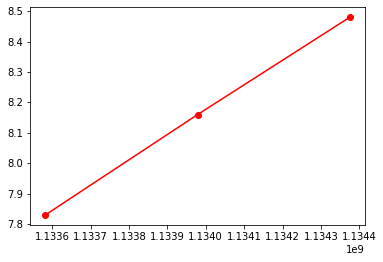

In [602]:
plt.plot([1133582617,1133978832,1134375046],[7.83, 8.16, 8.48], 'ro-')